In [1]:
# define logging and working directory
from ProjectRoot import change_wd_to_project_root 
change_wd_to_project_root()
from pyforest import *
from src.utils.notebook_imports import *
from src.utils.metrics_acdc import compute_metrics_on_files, compute_metrics_on_directories
from src.visualization.Visualize import bland_altman_metric_plot, create_eval_plot
Console_and_file_logger('Evaluation', logging.INFO)
import matplotlib.pyplot as plt
# jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2

search for root_dir and set working directory
Working directory set to: /mnt/data/git/cardio


2020-08-08 08:38:17,309 INFO -------------------- Start --------------------
2020-08-08 08:38:17,310 INFO Working directory: /mnt/data/git/cardio.
2020-08-08 08:38:17,310 INFO Log file: ./logs/Evaluation.log
2020-08-08 08:38:17,310 INFO Log level for console: INFO


In [50]:
# select folder with the images and masks
# choose the root folder before the gt/pred sub-folders
from ipyfilechooser import FileChooser
path_chooser = FileChooser(os.path.join(os.getcwd(),'data/predicted/'), '')
display(path_chooser)

FileChooser(path='/mnt/data/git/cardio/data/predicted', filename='', show_hidden='False')

In [51]:
root_path = path_chooser.selected

gt_path = os.path.join(root_path, 'gt')
#gt_path = 'data/temp/gt'
gt = sorted(glob.glob(os.path.join(gt_path, '*')))
logging.info('GT files: {}'.format(len(gt)))
logging.info(gt[:5])

pred_path = os.path.join(root_path, 'pred')
#pred_path = 'data/temp/pred'
pred = sorted(glob.glob(os.path.join(pred_path, '*')))
logging.info('Pred files: {}'.format(len(pred)))
logging.info(pred[:5])

# proof if we have one gt file for each prediction and vize versa
p = set(os.path.basename(elem) for elem in pred)
g = set(os.path.basename(elem) for elem in gt)
logging.info(g-p)
logging.info(p-g)
logging.info(len(p.intersection(g)))
compute_metrics_on_directories(gt_path, pred_path, results_path=os.path.join(root_path,'results.csv'))

2020-08-13 10:23:52,242 INFO GT files: 162
2020-08-13 10:23:52,258 INFO ['/mnt/data/git/cardio/data/predicted/temp_128_resample_post_down/3D/gt/0000-0HQQW4ZN_2007-05-23_ED_msk.nrrd', '/mnt/data/git/cardio/data/predicted/temp_128_resample_post_down/3D/gt/0000-0HQQW4ZN_2007-05-23_ES_msk.nrrd', '/mnt/data/git/cardio/data/predicted/temp_128_resample_post_down/3D/gt/0000-0PTV75MP_2005-06-27_ED_msk.nrrd', '/mnt/data/git/cardio/data/predicted/temp_128_resample_post_down/3D/gt/0000-0PTV75MP_2005-06-27_ES_msk.nrrd', '/mnt/data/git/cardio/data/predicted/temp_128_resample_post_down/3D/gt/0000-0RPELLU8_2007-02-13_ED_msk.nrrd']
2020-08-13 10:23:52,260 INFO Pred files: 162
2020-08-13 10:23:52,260 INFO ['/mnt/data/git/cardio/data/predicted/temp_128_resample_post_down/3D/pred/0000-0HQQW4ZN_2007-05-23_ED_msk.nrrd', '/mnt/data/git/cardio/data/predicted/temp_128_resample_post_down/3D/pred/0000-0HQQW4ZN_2007-05-23_ES_msk.nrrd', '/mnt/data/git/cardio/data/predicted/temp_128_resample_post_down/3D/pred/0000-

In [52]:
@interact
def load_evaluation(eval_path = sorted(glob.glob('data/predicted/**/**/*.csv'))):
    print(eval_path)
    import pandas as pd
    global eval, df_dice, df_hd, df_vol
    eval = pd.read_csv(eval_path)
    # df need to be melt down = every row represented by one value
    # first define melting/categorical columns, second define all values
    df_dice = pd.melt(eval, ['Name'], ['Dice LV', 'Dice RV', 'Dice MYO'])
    df_hd = pd.melt(eval, ['Name'], ['Err LV(ml)', 'Err RV(ml)', 'Err MYO(ml)'])
    df_vol = pd.melt(eval, ['Name'], ['Volume LV', 'Volume RV', 'Volume MYO'])
    create_eval_plot(df_dice, df_hd, df_vol, eval)
    return(eval.head())

interactive(children=(Dropdown(description='eval_path', options=('data/predicted/AX_to_SAX_to_AX/3D/results.cs…

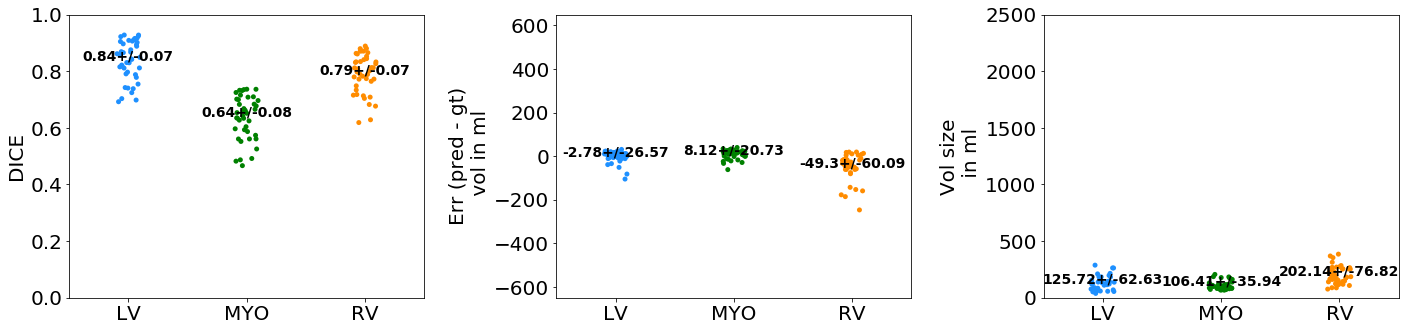

In [30]:
# create a scatterplot
# nobs = mean
import seaborn as sns
#plt.rcParams['font.fontname'] = "Cambria"
outliers = False

plt.rcParams.update({'font.size': 20})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5), sharey=False)
my_pal_1 = {"Dice LV": "dodgerblue", "Dice MYO": "g", "Dice RV":"darkorange"}
my_pal_2 = {"Err LV(ml)": "dodgerblue", "Err MYO(ml)": "g", "Err RV(ml)":"darkorange"}
my_pal_3 = {"Volume LV": "dodgerblue", "Volume MYO": "g", "Volume RV":"darkorange"}

ax1 = sns.stripplot(x= 'variable',y = 'value', data=df_dice,order=["Dice LV", "Dice MYO", "Dice RV"],palette=my_pal_1 , ax=ax1)
medians = df_dice.groupby(['variable'])['value'].mean().round(2)
sd = df_dice.groupby(['variable'])['value'].std().round(2)
nobs = ['{}+/-{}'.format(m,s) for m,s in zip(medians, sd)]

for tick,label in zip(range(len(ax1.get_xticklabels())),ax1.get_xticklabels()):
    _ = ax1.text(tick, medians[tick], nobs[tick],horizontalalignment='center', size='x-small', color='black', weight='semibold')
plt.setp(ax1, ylim=(0,1))
plt.setp(ax1, ylabel=('DICE'))
plt.setp(ax1, xlabel='')
ax1.set_xticklabels(['LV','MYO', 'RV'])

ax2 = sns.stripplot(x= 'variable',y = 'value', data=df_hd,order=["Err LV(ml)", "Err MYO(ml)", "Err RV(ml)"],palette=my_pal_2 , ax=ax2)
medians = df_hd.groupby(['variable'])['value'].mean().round(2)
sd = df_hd.groupby(['variable'])['value'].std().round(2)
nobs = ['{}+/-{}'.format(m,s) for m,s in zip(medians, sd)]

for tick,label in zip(range(len(ax2.get_xticklabels())),ax2.get_xticklabels()):
    _ = ax2.text(tick, medians[tick], nobs[tick],horizontalalignment='center', size='x-small', color='black', weight='semibold')
plt.setp(ax2, ylim=(-650,650))
plt.setp(ax2, ylabel=('Err (pred - gt)\n vol in ml'))
plt.setp(ax2, xlabel='')
ax2.set_xticklabels(['LV','MYO', 'RV'])
    
ax3 = sns.stripplot(x= 'variable',y = 'value',order=["Volume LV", "Volume MYO", "Volume RV"],palette=my_pal_3 , data=df_vol, ax=ax3)
medians = df_vol.groupby(['variable'])['value'].mean().round(2)
sd = df_vol.groupby(['variable'])['value'].std().round(2)
nobs = ['{}+/-{}'.format(m,s) for m,s in zip(medians, sd)]

for tick,label in zip(range(len(ax3.get_xticklabels())),ax3.get_xticklabels()):
    _ = ax3.text(tick, medians[tick], nobs[tick],horizontalalignment='center', size='x-small', color='black', weight='semibold')
plt.setp(ax3, ylim=(0,2500))
plt.setp(ax3, ylabel=('Vol size\n in ml'))
plt.setp(ax3, xlabel='')
ax3.set_xticklabels(['LV','MYO', 'RV'])
plt.tight_layout()

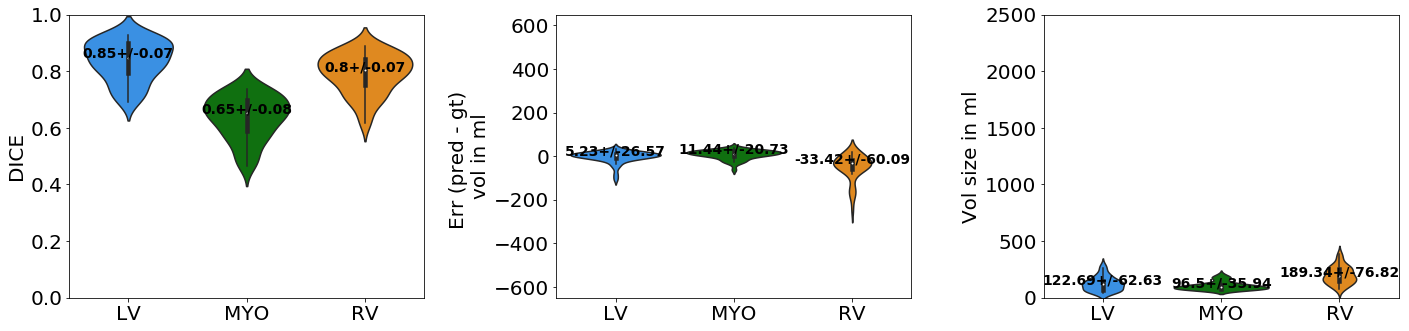

In [11]:
# create a violinplot
# nobs = median
import seaborn as sns
outliers = False


plt.rcParams.update({'font.size': 20})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5), sharey=False)

ax1 = sns.violinplot(x= 'variable',y = 'value', data=df_dice,order=["Dice LV", "Dice MYO", "Dice RV"], palette=my_pal_1 , showfliers = outliers, ax=ax1)
medians = df_dice.groupby(['variable'])['value'].median().round(2)
sd = df_dice.groupby(['variable'])['value'].std().round(2)
nobs = ['{}+/-{}'.format(m,s) for m,s in zip(medians, sd)]

for tick,label in zip(range(len(ax1.get_xticklabels())),ax1.get_xticklabels()):
    _ = ax1.text(tick, medians[tick], nobs[tick],horizontalalignment='center', size='x-small', color='black', weight='semibold')
plt.setp(ax1, ylim=(0,1))
plt.setp(ax1, ylabel=('DICE'))
plt.setp(ax1, xlabel='')
ax1.set_xticklabels(['LV','MYO', 'RV'])

ax2 = sns.violinplot(x= 'variable',y = 'value', data=df_hd,order=["Err LV(ml)", "Err MYO(ml)", "Err RV(ml)"],palette=my_pal_2 , showfliers = outliers, ax=ax2)
medians = df_hd.groupby(['variable'])['value'].median().round(2)
sd = df_hd.groupby(['variable'])['value'].std().round(2)
nobs = ['{}+/-{}'.format(m,s) for m,s in zip(medians, sd)]

for tick,label in zip(range(len(ax2.get_xticklabels())),ax2.get_xticklabels()):
    _ = ax2.text(tick, medians[tick], nobs[tick],horizontalalignment='center', size='x-small', color='black', weight='semibold')
plt.setp(ax2, ylim=(-650,650))
plt.setp(ax2, ylabel=('Err (pred - gt) \nvol in ml'))
plt.setp(ax2, xlabel='')
ax2.set_xticklabels(['LV','MYO', 'RV'])
    
ax3 = sns.violinplot(x= 'variable',y = 'value',order=["Volume LV", "Volume MYO", "Volume RV"],palette=my_pal_3 , showfliers = outliers, data=df_vol, ax=ax3)

medians = df_vol.groupby(['variable'])['value'].median().round(2)
sd = df_vol.groupby(['variable'])['value'].std().round(2)
nobs = ['{}+/-{}'.format(m,s) for m,s in zip(medians, sd)]


for tick,label in zip(range(len(ax3.get_xticklabels())),ax3.get_xticklabels()):
    _ = ax3.text(tick, medians[tick], nobs[tick],horizontalalignment='center', size='x-small', color='black', weight='semibold')
plt.setp(ax3, ylim=(0,2500))
plt.setp(ax3, ylabel=('Vol size in ml'))
plt.setp(ax3, xlabel='')
ax3.set_xticklabels(['LV','MYO', 'RV'])
plt.tight_layout()

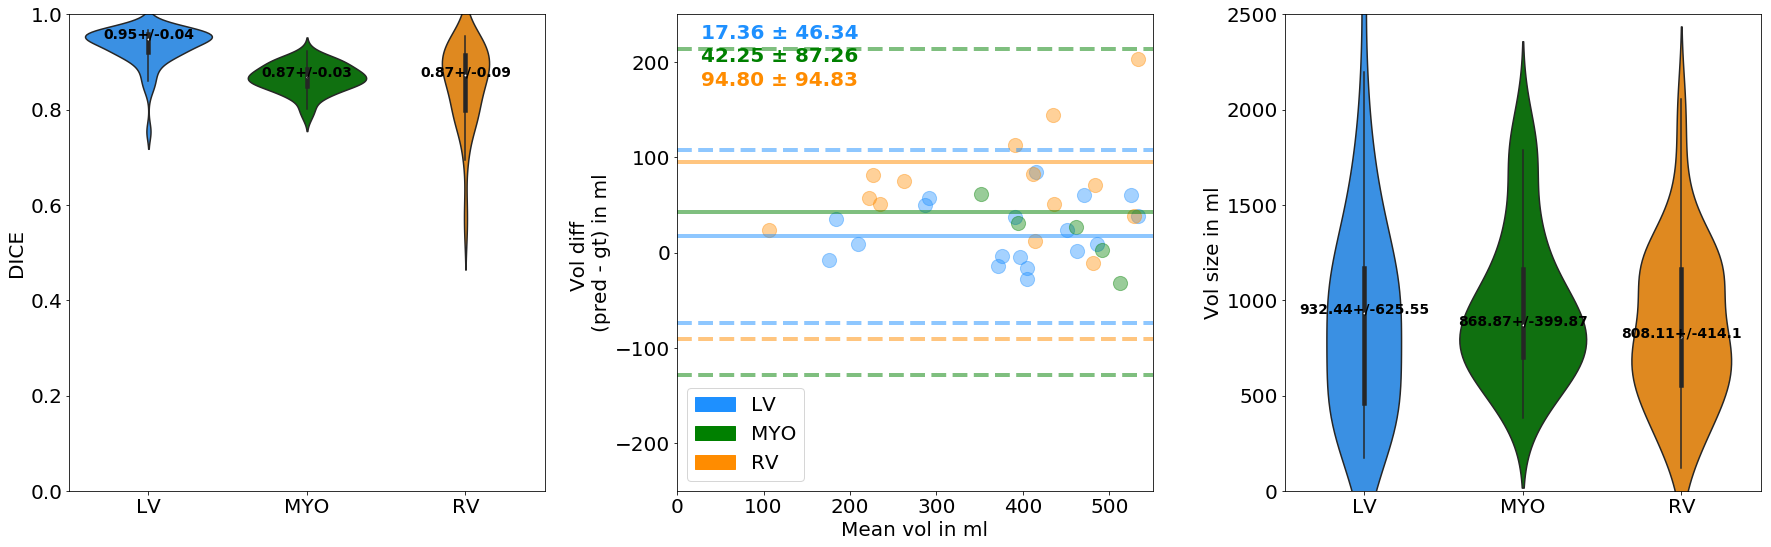

In [26]:
# create a violinplot with an integrated bland altmann plot
# nobs = median
import seaborn as sns
outliers = False
my_pal_1 = {"Dice LV": "dodgerblue", "Dice MYO": "g", "Dice RV":"darkorange"}
my_pal_2 = {"Err LV(ml)": "dodgerblue", "Err MYO(ml)": "g", "Err RV(ml)":"darkorange"}
my_pal_3 = {"Volume LV": "dodgerblue", "Volume MYO": "g", "Volume RV":"darkorange"}


plt.rcParams.update({'font.size': 20})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,8), sharey=False)

ax1 = sns.violinplot(x= 'variable',y = 'value', data=df_dice,order=["Dice LV", "Dice MYO", "Dice RV"],palette=my_pal_1 , showfliers = outliers, ax=ax1)
medians = df_dice.groupby(['variable'])['value'].median().round(2)
sd = df_dice.groupby(['variable'])['value'].std().round(2)
nobs = ['{}+/-{}'.format(m,s) for m,s in zip(medians, sd)]

for tick,label in zip(range(len(ax1.get_xticklabels())),ax1.get_xticklabels()):
    _ = ax1.text(tick, medians[tick], nobs[tick],horizontalalignment='center', size='x-small', color='black', weight='semibold')
plt.setp(ax1, ylim=(0,1))
plt.setp(ax1, ylabel=('DICE'))
plt.setp(ax1, xlabel='')
ax1.set_xticklabels(['LV','MYO', 'RV'])

ax2 = bland_altman_metric_plot(eval, ax2)

ax3 = sns.violinplot(x= 'variable',y = 'value',order=["Volume LV", "Volume MYO", "Volume RV"], palette=my_pal_3, showfliers = outliers, data=df_vol, ax=ax3)

medians = df_vol.groupby(['variable'])['value'].median().round(2)
sd = df_vol.groupby(['variable'])['value'].std().round(2)
nobs = ['{}+/-{}'.format(m,s) for m,s in zip(medians, sd)]


for tick,label in zip(range(len(ax3.get_xticklabels())),ax3.get_xticklabels()):
    _ = ax3.text(tick, medians[tick], nobs[tick],horizontalalignment='center', size='x-small', color='black', weight='semibold')
plt.setp(ax3, ylim=(0,2500))
plt.setp(ax3, ylabel=('Vol size in ml'))
plt.setp(ax3, xlabel='')
ax3.set_xticklabels(['LV','MYO', 'RV'])
plt.tight_layout()

In [53]:
def calc_mean_scores(df):
    
    df_dice = pd.melt(df, ['Name'], ['Dice LV', 'Dice RV', 'Dice MYO'])
    df_hd = pd.melt(df, ['Name'], ['Err LV(ml)', 'Err RV(ml)', 'Err MYO(ml)'])
    df_vol = pd.melt(df, ['Name'], ['Volume LV', 'Volume RV', 'Volume MYO'])
    
    d_mean = df['Dice LV', 'Dice RV', 'Dice MYO'].mean()
    d_median = df['Dice LV', 'Dice RV', 'Dice MYO'].median()
    d_sd = df['Dice LV', 'Dice RV', 'Dice MYO'].sd()
    df = pd.DataFrame()
    
    df.extend(medians_dice = df_dice.groupby(['variable'])['value'].median().round(2))
    mean_dice = df_dice.groupby(['variable'])['value'].mean().round(2)
    sd_dice = df_dice.groupby(['variable'])['value'].std().round(2)
    
    medians_hd = df_dice.groupby(['variable'])['value'].median().round(2)
    sd_hd = df_dice.groupby(['variable'])['value'].std().round(2)
    
    medians_vol = df_dice.groupby(['variable'])['value'].median().round(2)
    sd_vol = df_dice.groupby(['variable'])['value'].std().round(2)
    
    return d_mean, d_median, d_sd
    

In [81]:
cols = ['dice LV median','dice RV median','dice MYO median', 'dice LV mean', 'dice RV mean','dice MYO mean', 'dice LV sd', 'dice RV sd', 'dice MYO sd']
scores = []

scores.extend(df_dice.groupby(['variable'])['value'].median().round(2).values)
scores.extend(df_dice.groupby(['variable'])['value'].mean().round(2).values)
scores.extend(df_dice.groupby(['variable'])['value'].std().round(2).values)

df = pd.DataFrame(columns=cols)
df.append(scores)
df

,dice LV median,dice RV median,dice MYO median,dice LV mean,dice RV mean,dice MYO mean,dice LV sd,dice RV sd,dice MYO sd


In [33]:
def get_dice(exp):
    df = pd.read_csv(exp)
    d_lv = df.iloc[:,1]
    d_rv = df.iloc[:,4]
    d_myo = df.iloc[:,7]
    return [{'experiment':exp, 'dice lv mean':d_lv.mean(), 'dice lv sd':d_lv.std(),'dice lv median':d_lv.median(),  'dice rv mean':d_rv.mean(), 'dice rv sd':d_rv.std(),'dice rv median':d_rv.median(), 'dice myo mean':d_myo.mean(), 'dice myo sd':d_myo.std(),'dice myo median':d_myo.median()}]

In [34]:
df_scores = pd.DataFrame( columns=['experiment', 'dice lv mean', 'dice lv sd', 'dice lv median', 'dice rv mean', 'dice rv sd','dice rv median',  'dice myo mean', 'dice myo sd','dice myo median'])
@interact_manual
def load_evaluation(eval_path = sorted(glob.glob('data/predicted/**/**/*.csv'))):
    global df_scores
    print(eval_path)
    import pandas as pd

    df_scores = df_scores.append(get_dice(eval_path))

    return df_scores.round(2)


interactive(children=(Dropdown(description='eval_path', options=('data/predicted/AX_to_SAX_to_AX/3D/results.cs…

In [17]:
df_scores.to_excel('data/temp/tmi_overview.xls',index=False)

# Show all predictions between two relative borders

In [12]:
# explore outliers Dice
@interact
def explore_outliers(df_selected = ["df_dice", "df_hd", "df_vol"], min_=(0,1,0.1), max_=(0,1,0.1)):
    print(df_selected)
    
    df = globals().get(df_selected).copy()
    orders = list(df.variable.unique())
    print(df.describe())
    df = df[df['value'] >= df['value'].max() * float(min_)]
    df = df[df['value'] <= df['value'].max() * float(max_)]
    #orders = ["Dice LV", "Dice MYO", "Dice RV"]
    
    plt.rcParams.update({'font.size': 20})
    fig, (ax1) = plt.subplots(1, 1, figsize=(25,10), sharey=False)
    ax1 = sns.stripplot(x= 'variable',y = 'value', data=df,order=orders, ax=ax1)
    medians = df.groupby(['variable'])['value'].mean().round(2)
    sd = df.groupby(['variable'])['value'].std().round(2)
    nobs = ['{}+/-{}'.format(m,s) for m,s in zip(medians, sd)]
    return df.Name
    

interactive(children=(Dropdown(description='df_selected', options=('df_dice', 'df_hd', 'df_vol'), value='df_di…

In [22]:
# explore outliers Dice

from ipywidgets import IntSlider

@interact
def explore_outliers(df_selected = ["df_dice", "df_hd", "df_vol"], 
                     low = IntSlider(min=0,max=3,step=1,value=0), 
                     high =IntSlider(min=0,max=3,step=1,value=3), 
                     examples=IntSlider(min=0,max=50,step=1,value=10), 
                     smallest=True):
    """
    Select a dataframe, define the label of interests and show the n best/worst examples
    params:
    df_selected: select "DICE", "vol difference" or "abolute vol" dataframe
    low: Interpret the labels as int list 0 - 3, define a range of labels with low and high, order: LV,MYO,RV
    high: upper labels limit
    examples: Define the number of lowest performer for this df and labels
    smallest: You can pick the smallest or highest dice scores with smallest=False/True
    """
    
    print(df_selected)
    
    # create a copy of the selected dataframe
    df = globals().get(df_selected).copy()
    # create a list of labels
    orders = sorted(list(df.variable.unique()))[low:high]
    # filter rows by selected labels
    df = df[df['variable'].isin(orders)]
    
    print(df.describe())
    if smallest:
        df = df.nsmallest(examples, columns=['value'])
    else:
         df = df.nlargest(examples, columns=['value'])
    #orders = ["Dice LV", "Dice MYO", "Dice RV"]
    
    plt.rcParams.update({'font.size': 20})
    fig, (ax1) = plt.subplots(1, 1, figsize=(25,10), sharey=False)
    ax1 = sns.stripplot(x= 'variable',y = 'value', data=df,order=orders, ax=ax1)
    medians = df.groupby(['variable'])['value'].mean().round(2)
    sd = df.groupby(['variable'])['value'].std().round(2)
    nobs = ['{}+/-{}'.format(m,s) for m,s in zip(medians, sd)]
    return df.Name

interactive(children=(Dropdown(description='df_selected', options=('df_dice', 'df_hd', 'df_vol'), value='df_di…